In [236]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random

In [237]:
segment_directory = "data/segmentation.csv"
segment = pd.read_csv(segment_directory, header=0 )

In [238]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


In [239]:
segment.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,3.950687,0.500008,0.497864,0.495451,0.498427
std,179.809263,5.189864,0.290144,0.291103,0.289034,0.288478
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033
25%,20.910000,1.000000,0.250000,0.240000,0.242545,0.248739
50%,59.275000,2.000000,0.500000,0.500000,0.496410,0.498833
75%,170.000000,5.000000,0.750000,0.750000,0.744476,0.747424
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999943


In [240]:
features = ['Monetary', 'Frequency', 'factor_1', 'factor_2', 'factor_3' , 'factor_4']

Для разделения на кластеры по платежному поведению, применим алгоритм кластеризации K means. 

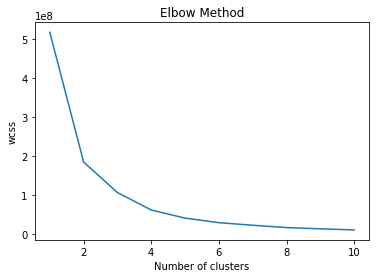

In [241]:
#Используем Elbow Method чтобы найти оптимальное количество кластеров
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++')
    km.fit(segment[features])
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [242]:
model = KMeans(n_clusters=4)
model.fit(segment[features])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [243]:
all_predictions = model.predict(segment[features])

In [244]:
# Для отображения кластеров используем метод главных компонент. Перед его использованием
# нормализуем все переменные
from sklearn.preprocessing import StandardScaler
x = segment.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [245]:
feat_cols = [i+'_norm' for i in features]
normalised_segment = pd.DataFrame(x,columns=feat_cols)
normalised_segment.head()

,Monetary_norm,Frequency_norm,factor_1_norm,factor_2_norm,factor_3_norm,factor_4_norm
0,-0.164470,0.394881,-0.517028,-1.435496,0.395429,1.563272
1,0.222619,0.009502,0.551439,-1.160670,1.545961,-0.064414
2,-0.329372,0.394881,1.447573,-1.023257,-0.596558,-1.703306
3,-0.305735,1.165638,-0.517028,0.969228,1.319546,-1.419400
4,-0.197228,0.202191,0.034439,-0.198781,1.441563,-1.013049


In [246]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalised_segment)
normalised_segment['pca_one'] = pca_result[:,0]
normalised_segment['pca_two'] = pca_result[:,1]
normalised_segment['pca_three'] = pca_result[:,2] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.28417313 0.16983968 0.16737041]


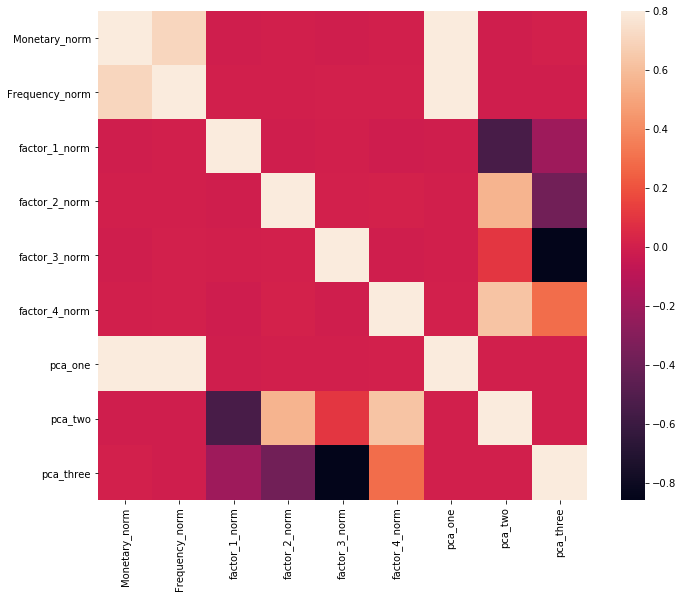

In [247]:
#correlation matrix
corrmat = normalised_segment.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Как видно из тепловой карты за платежную активность отвечает pca_one

In [248]:
#Ставим лейблы
normalised_segment['label'] = all_predictions
segment['label'] = all_predictions

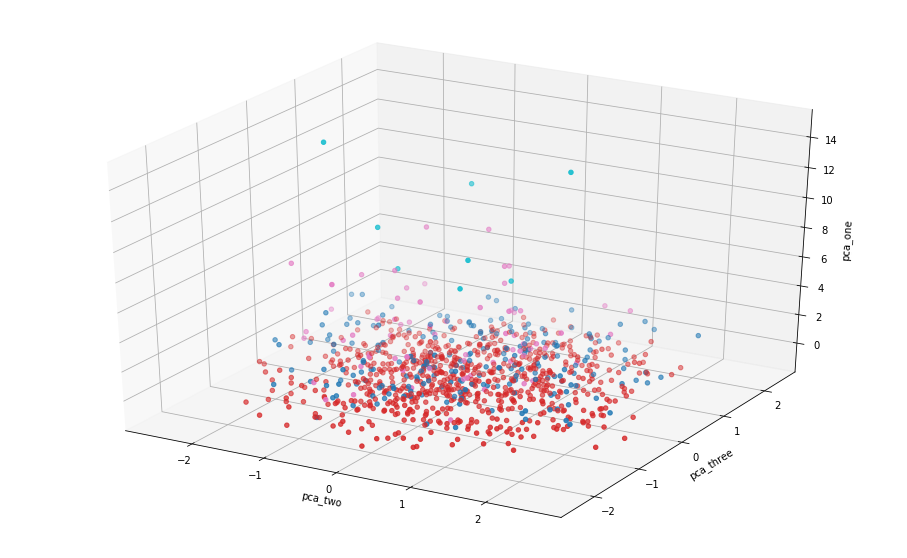

In [249]:
#Визуализируем кластеры
rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=normalised_segment.loc[rndperm,:]["pca_two"], 
    ys=normalised_segment.loc[rndperm,:]["pca_three"], 
    zs=normalised_segment.loc[rndperm,:]["pca_one"], 
    c=normalised_segment.loc[rndperm,:]["label"],
    cmap='tab10'
)
ax.set_xlabel('pca_two')
ax.set_ylabel('pca_three')
ax.set_zlabel('pca_one')
plt.show()

In [252]:
# Выводим среднее значения факторов в разных кластерах
segment.groupby('label').mean().sort_values(by=['Monetary'])

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4
label,,,,,,
1,44.999347,2.284551,0.501896,0.497918,0.495796,0.497586
0,240.674781,6.418342,0.493796,0.495951,0.495489,0.504122
2,543.158518,10.752483,0.499089,0.503634,0.489474,0.488820
3,1301.343043,33.391304,0.499348,0.483587,0.529646,0.525712


In [253]:
segment.groupby('label').agg({'label': 'count'})

,label
label,
0,3282
1,11418
2,1208
3,92


Меньше всех несет информации factor_1. 
Я выделил 4 сегмента:
- label 1: юзеры с низкой платежной активностью (наибольший сегмент)
- label 0: юзеры со средней платежной активностью 
- label 2: юзеры с высокой платежной активностью 
- label 3: юзеры с самой высокой платежной активностью (наименьший сегмент)